**The objective of this challenge is to forecast the number of turtles caught per week per capture site. This will help Local Ocean plan their staff schedules and budget.**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option("display.max_columns", 200, "display.max_rows", 200)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
turtle = pd.read_csv("train.csv", delimiter=",")
varDesc = pd.read_csv("variable_definitions.csv", engine="python")
submissionSample = pd.read_csv("Sample_sub.csv")
turtle.shape

initialRows = turtle.shape[0]

In [3]:
varDesc

,Variables,Description
0,Rescue_ID,It�s an individual bycatch incidence identity ...
1,Date_TimeCaught,Date the turtle is captured e.g. 06/01/2018
2,Researcher,Name of bycatch officer(s) involved with speci...
3,Capture Site,"Area where turtle was captured, as reported by..."
4,Foraging Ground,General area of ocean area where turtle was ca...
5,Capture Method,Fishing gear or method used by fishers to capt...
6,Fisher,Name of the fisher who captured the turtle
7,Landing_Site,Section of beach where turtle is landed.
8,Species,"Species of turtle (e.g. green turtle, hawksbil..."
9,Tag_1,Individual / unique number used to identify a ...


In [4]:
varDesc.loc[5, "Description"]

'Fishing gear or method used by fishers to capture the turtle'

In [5]:
turtle.head()

,Rescue_ID,Date_TimeCaught,Researcher,CaptureSite,ForagingGround,CaptureMethod,Fisher,LandingSite,Species,Tag_1,Tag_2,Lost_Tags,T_Number,CCL_cm,CCW_cm,Weight_Kg,Sex,TurtleCharacteristics,Status,ReleaseSite,Date_TimeRelease
0,2000_RE_0060,2000-12-22,Researcher_25,CaptureSite_0,Ocean,Net,Fisher_1072,LandingSite_CaptureSiteCategory_2,Species_6,CC00147,None,NaN,NaN,64.70,62.60,NaN,Unknown,algae at rear of shell,Released,ReleaseSite_50,22/12/00
1,2001_RE_0187,2001-10-28,Researcher_6,CaptureSite_0,Ocean,Net,Fisher_520,LandingSite_CaptureSiteCategory_2,Species_6,W442,None,NaN,NaN,35.85,31.35,NaN,Unknown,multiple b's on front flippers& a lot of alga...,Released,ReleaseSite_62,28/10/01
2,2001_RE_0197,2001-11-01,Researcher_6,CaptureSite_0,Ocean,Net,Fisher_1669,LandingSite_CaptureSiteCategory_2,Species_5,KE0376,None,NaN,NaN,51.80,49.20,NaN,Unknown,clean,Released,ReleaseSite_50,01/11/01
3,2002_RE_0031,2002-03-11,Researcher_32,CaptureSite_0,Ocean,Net,Fisher_1798,LandingSite_CaptureSiteCategory_2,Species_6,CC00302,None,NaN,NaN,60.50,59.00,NaN,Unknown,1 b 3 CS+ calcerous algae at rear end of shell...,Released,ReleaseSite_50,11/03/02
4,2002_RE_0118,2002-08-08,Researcher_25,CaptureSite_0,Ocean,Beached,Fisher_1918,LandingSite_CaptureSiteCategory_2,Species_5,NotTagged_0113,None,NaN,NaN,34.70,33.00,NaN,Unknown,very lively+ right eye is hanging out + swolle...,Released,ReleaseSite_62,08/08/02


In [6]:
turtle.isnull().sum()

Rescue_ID                    0
Date_TimeCaught              0
Researcher                   0
CaptureSite                  0
ForagingGround               0
CaptureMethod                0
Fisher                       0
LandingSite                  0
Species                      0
Tag_1                        0
Tag_2                        0
Lost_Tags                17137
T_Number                 18024
CCL_cm                      24
CCW_cm                      27
Weight_Kg                 5409
Sex                       4330
TurtleCharacteristics       41
Status                    3633
ReleaseSite                 75
Date_TimeRelease          6108
dtype: int64

In [7]:
turtle.fillna(value={"Weight_Kg": 0, "Sex": "Unknown", "Lost_Tags": "None", "T_Number": "None"}, inplace=True)

There are some identified inconsisenties: 
* For example, "Creek" and "creek" both mean the same thing. In this case, we will capitalize all entries within the said variable. <br>
* Converting the date variables to date time datatype. <br> 
* Date_TimeRelease has multiple null values. Instead of dropping them, for the row values with a released status, include the Date_TimeCaught. <br>
* For the Status values that are not equal to Released and have a non null Date_TimeReleased, mark them as Released. <br>

In [8]:
turtle["ForagingGround"] = turtle["ForagingGround"].apply(lambda x: str(x).capitalize())
turtle["CaptureMethod"] = turtle["CaptureMethod"].apply(lambda x: str(x).capitalize())

In [9]:
# convert to datetime datatype
turtle["Date_TimeCaught"] = pd.to_datetime(turtle["Date_TimeCaught"])
turtle[["Date_TimeCaught", "Date_TimeRelease"]].dtypes

Date_TimeCaught     datetime64[ns]
Date_TimeRelease            object
dtype: object

In [10]:
# separate the year and week from the date provided
turtle["Date_TimeCaughtYear"] = turtle["Date_TimeCaught"].apply(lambda x: x.strftime("%Y"))
turtle["Date_TimeCaughtWeek"] = turtle["Date_TimeCaught"].apply(lambda x: x.strftime("%W"))

turtle[["Date_TimeCaughtYear", "Date_TimeCaughtWeek"]].head()

,Date_TimeCaughtYear,Date_TimeCaughtWeek
0,2000,51
1,2001,43
2,2001,44
3,2002,10
4,2002,31


It appears that most of the turtles are released on the same day they are captured. With this information, we will fill in the null released date for turtles with the released status similar to the date they were caught.

In [11]:
turtle["Date_TimeRelease"] = np.where((turtle["Date_TimeRelease"].isnull()) & (turtle["Status"] == "Released"), turtle["Date_TimeCaught"], turtle["Date_TimeRelease"])

In [12]:
turtle["Status"] = np.where((turtle["Date_TimeRelease"].notnull()) & (turtle["Status"] != "Released"), "Released", turtle["Status"])

All turtles that were admitted, do not have a release date. The assumption in this case would be that all admitted turtles are not released.
<br><br>
The Status column is very messy. For that reason, it shall be dropped.

In [13]:
turtle["Status"].unique()

array(['Released', nan, 'Admitted',
       ' 6 LLS& small notch in the joints between both 10th and 11th MS',
       'Not_Recorded',
       ' B on 2nd RLS& small bs on neck & RFs& scratch on 1st CS& 1b on 10th LMS+ L supracaudal +11th RM',
       ' small v-shaped notch on LRF', ' shell is beginning to flake',
       ' light pink calcerous', ' green algae towards rear carapace',
       ' 3rd CS is beginning to flake',
       ' the 2nd 3rd of both FFS from tips are jagged',
       ' a small projection on the middle of RRF', ' clean plastron',
       ' thick green algae on rear shell and rear flippers',
       ' few small barnacles on the plastron',
       ' slight chipping of all scutes& which were slightly elevated',
       ' tag rip in LRF', ' hook injury in the right shoulder',
       ' bleeding bruise at top of RFF', ' 1 b 5 CS & 1 small',
       ' sm bs 2RLS& both 11MS & 2LLS', ' sm bs on 1RLS and 3LLS',
       ' deep large cut(2Green Turtle)on soft flesh next to LFF (from hook)& 2b

## Exploratory Data Analysis

[Text(0, 0.5, 'Foraging Ground'),
 Text(0.5, 0, 'Number of Turtles'),
 Text(0.5, 1.0, 'Foraging Grounds Distribution of the Turtles')]

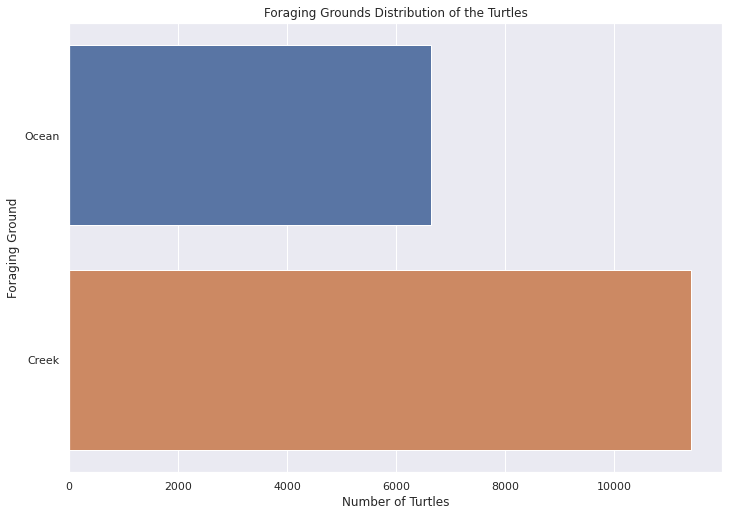

In [14]:
sns.countplot(y="ForagingGround", 
              data=turtle).set(title="Foraging Grounds Distribution of the Turtles", 
                               xlabel="Number of Turtles", ylabel="Foraging Ground")

Most of the captured turtles were foraging in the Creek area. Is this common for turtles?

[Text(0, 0.5, 'Method of Capture'),
 Text(0.5, 0, 'Number of Turtles'),
 Text(0.5, 1.0, 'Capture Method Distribution')]

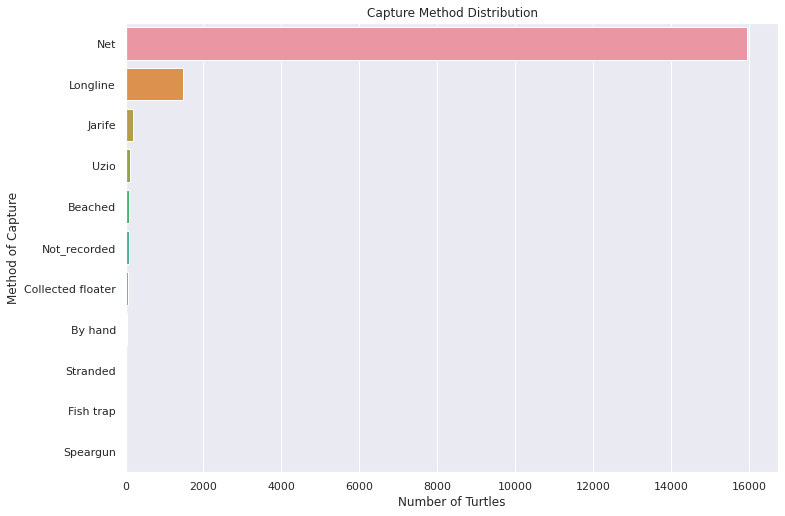

In [15]:
sns.countplot(y="CaptureMethod", data=turtle, 
              order=turtle["CaptureMethod"].value_counts().index).set(title="Capture Method Distribution", 
                                                                      xlabel="Number of Turtles", 
                                                                      ylabel="Method of Capture")

Most of the turtles were captured by a net.

[Text(0.5, 0, 'Number of Turtles'),
 Text(0.5, 1.0, 'Status Distribution of the Captured Turtles')]

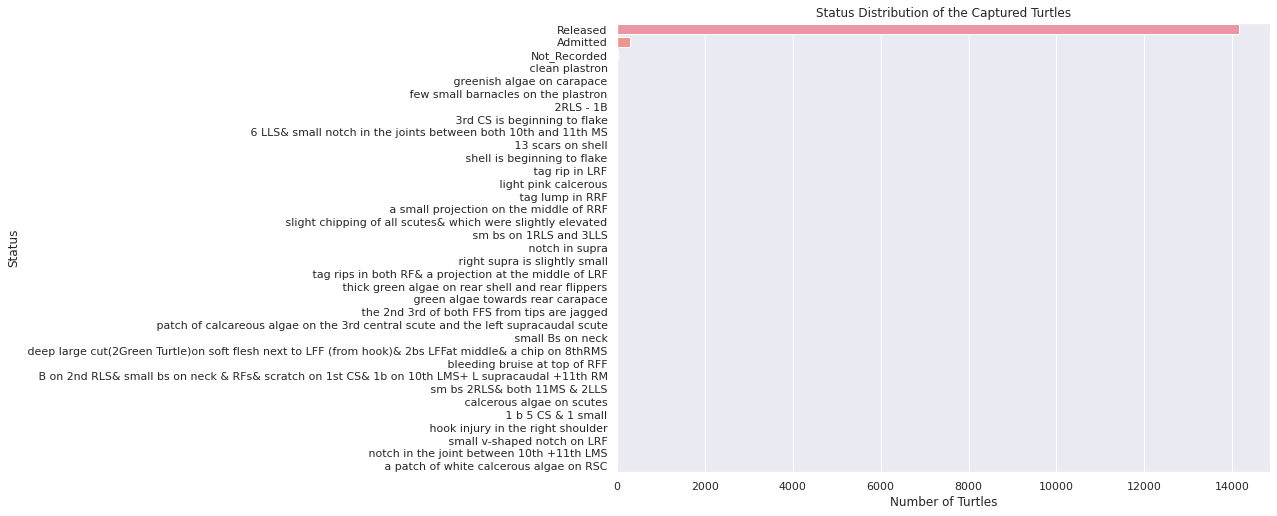

In [16]:
sns.countplot(y="Status", data=turtle, 
              order=turtle["Status"].value_counts().index
             ).set(title="Status Distribution of the Captured Turtles", xlabel="Number of Turtles")

The status column is very messy. It would have additional guiding information. However, it is also skewed towards the Released state.

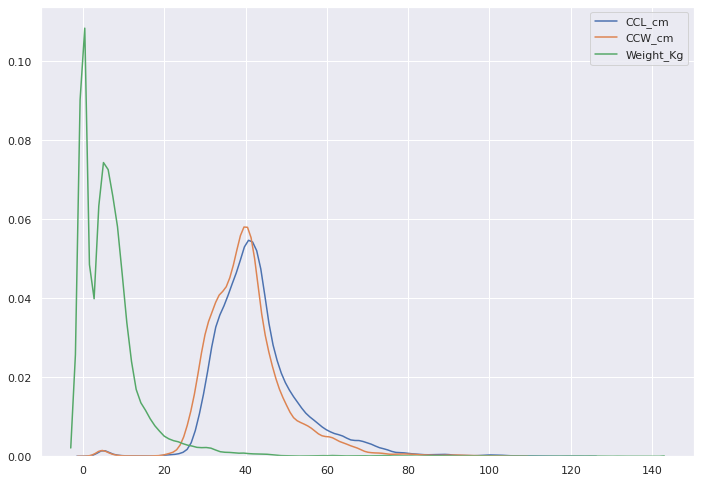

In [17]:
for column in [col for col in turtle.columns if turtle[col].dtype == "float"]:
    sns.kdeplot(turtle[column], label=column)

The graph above indicates that there is skewness in the dataset within the numerical variables. There is also presence of outliers in the data set.

In [18]:
turtle.replace({"Sex": {"Not_Recorded": "Unknown"}}, inplace=True)
turtle["Sex"].unique()

array(['Unknown', 'Female', 'Male'], dtype=object)

In [19]:
submissionSample.head(2)

,ID,Capture_Number
0,CaptureSite_0_201901,7
1,CaptureSite_0_201902,1


In [20]:
# create the column to match as is in the submission sample
turtle["ID"] = turtle["CaptureSite"] + "_" + turtle["Date_TimeCaughtYear"] + turtle["Date_TimeCaughtWeek"]
turtle[["ID", "CaptureSite"]].head()

,ID,CaptureSite
0,CaptureSite_0_200051,CaptureSite_0
1,CaptureSite_0_200143,CaptureSite_0
2,CaptureSite_0_200144,CaptureSite_0
3,CaptureSite_0_200210,CaptureSite_0
4,CaptureSite_0_200231,CaptureSite_0


In [21]:
trainTurtle = turtle.groupby(["ID", "CaptureSite", "Date_TimeCaughtYear", 
                              "Date_TimeCaughtWeek"]).agg({"Rescue_ID": "count", "Researcher": "nunique", 
                                                           "LandingSite": "nunique", 
                                                           "ForagingGround": "nunique", 
                                                           "CaptureMethod": "nunique", "Fisher": "nunique", 
                                                           "Species": "nunique", "Lost_Tags": "nunique", 
                                                           "CCL_cm": "mean", "CCW_cm": "mean", 
                                                           "Weight_Kg": "mean", "Sex": "nunique", 
                                                           "Status": "nunique", 
                                                           "ReleaseSite": "nunique"}).reset_index()
trainTurtle.shape

(7971, 18)

In [22]:
trainTurtle.rename(columns={"Rescue_ID": "Capture_Number"}, inplace=True)
trainTurtle["Date_TimeCaughtWeek"] = trainTurtle["Date_TimeCaughtWeek"].astype(int)
trainTurtle["Date_TimeCaughtYear"] = trainTurtle["Date_TimeCaughtYear"].astype(int)
trainTurtle["Date_TimeCaughtYear"] = pd.to_numeric(trainTurtle["Date_TimeCaughtYear"])

trainTurtle.sort_values(by=["Capture_Number"], ascending=False).head()

,ID,CaptureSite,Date_TimeCaughtYear,Date_TimeCaughtWeek,Capture_Number,Researcher,LandingSite,ForagingGround,CaptureMethod,Fisher,Species,Lost_Tags,CCL_cm,CCW_cm,Weight_Kg,Sex,Status,ReleaseSite
5166,CaptureSite_25_200847,CaptureSite_25,2008,47,35,1,1,1,1,7,1,3,48.831429,45.380000,0.000000,1,1,1
5170,CaptureSite_25_200851,CaptureSite_25,2008,51,28,1,1,1,1,3,1,2,49.278571,46.089286,0.000000,1,0,2
5916,CaptureSite_27_201307,CaptureSite_27,2013,7,23,4,1,1,1,4,1,3,58.982609,53.278261,31.032609,2,2,4
5167,CaptureSite_25_200848,CaptureSite_25,2008,48,22,1,1,1,2,5,1,5,48.827273,45.327273,0.000000,1,0,1
5175,CaptureSite_25_200903,CaptureSite_25,2009,3,21,1,1,1,1,2,1,3,50.838095,47.247619,0.000000,1,0,2


[Text(0, 0.5, 'Number of Researchers'),
 Text(0.5, 0, 'Number of Turtles'),
 Text(0.5, 1.0, 'Number of Researchers against the Number of Captured Turtles')]

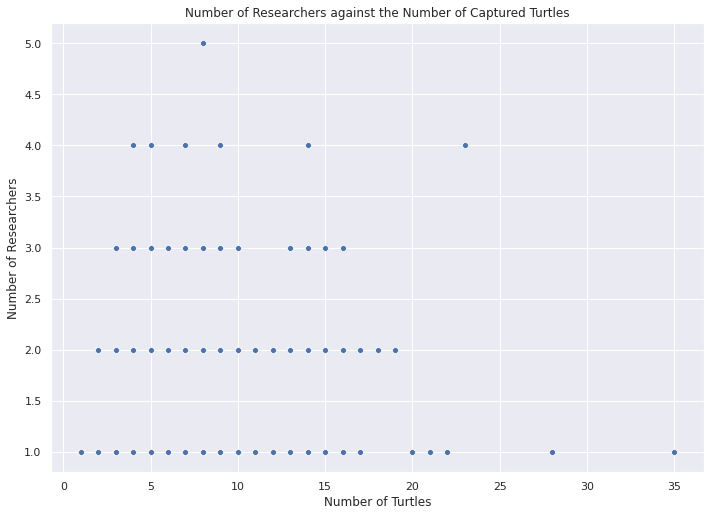

In [23]:
sns.scatterplot(x="Capture_Number", y="Researcher", 
                data=trainTurtle).set(title="Number of Researchers against the Number of Captured Turtles", 
                                      xlabel="Number of Turtles", ylabel="Number of Researchers")

[Text(0.5, 0, 'Number of Turtles'),
 Text(0.5, 1.0, 'CCL_cm against the Number of Captured Turtles')]

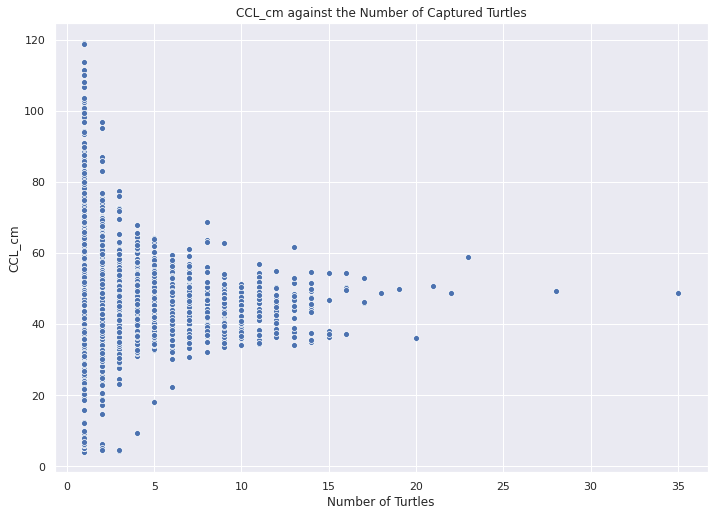

In [24]:
sns.scatterplot(x="Capture_Number", y="CCL_cm", 
                data=trainTurtle).set(title="CCL_cm against the Number of Captured Turtles", 
                                      xlabel="Number of Turtles")

[Text(0, 0.5, 'Weight(Kg)'),
 Text(0.5, 0, 'Number of Turtles'),
 Text(0.5, 1.0, 'Weight against Number of Captured Turtles')]

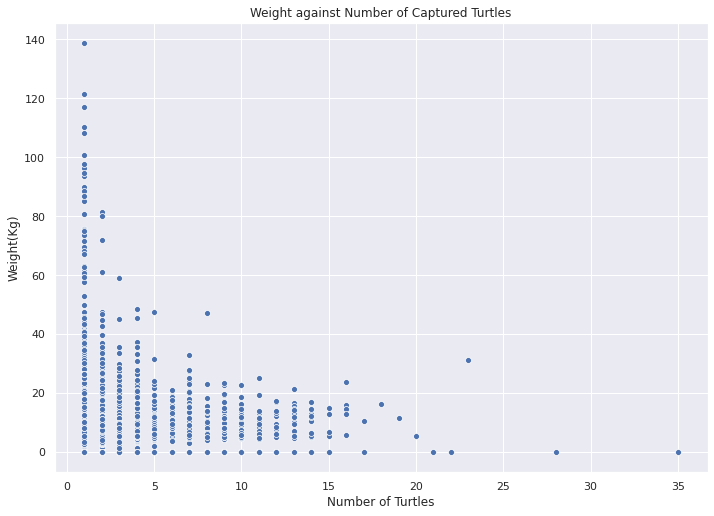

In [25]:
sns.scatterplot(x="Capture_Number", y="Weight_Kg", 
                data=trainTurtle).set(title="Weight against Number of Captured Turtles", 
                                      xlabel="Number of Turtles", ylabel="Weight(Kg)")

There is really no relationship between the numerical features and the capture number. This indicates that it is a **Time Series Forecasting** kind of a problem. With that, we will continue to explore trends and proceed to explore: 
* Autoregressive-Moving-Average<br> 
* Simple Moving Average

[Text(0, 0.5, 'Number of Turtles'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Yearly Distribution of the Captured Turtles')]

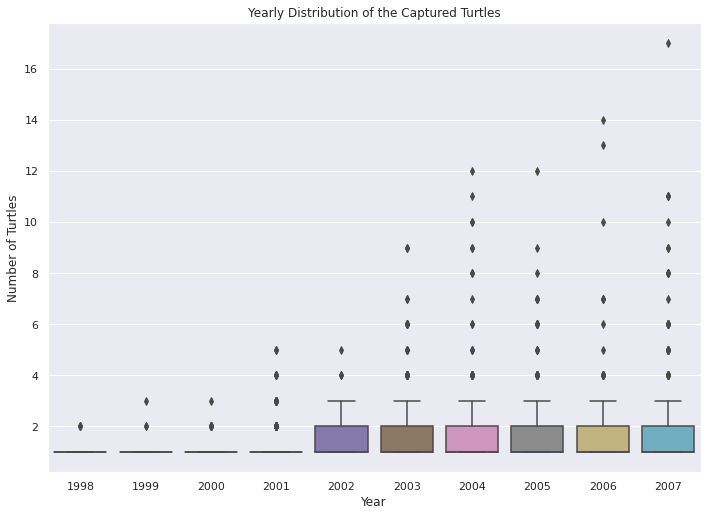

In [26]:
sns.boxplot(x="Date_TimeCaughtYear", y="Capture_Number", 
            data=trainTurtle[
                (trainTurtle["Date_TimeCaughtYear"] > 1997) & (trainTurtle["Date_TimeCaughtYear"] < 2008)]
           ).set(title="Yearly Distribution of the Captured Turtles", xlabel="Year", 
                 ylabel="Number of Turtles")

[Text(0, 0.5, 'Number of Turtles'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Yearly Distribution of the Captured Turtles')]

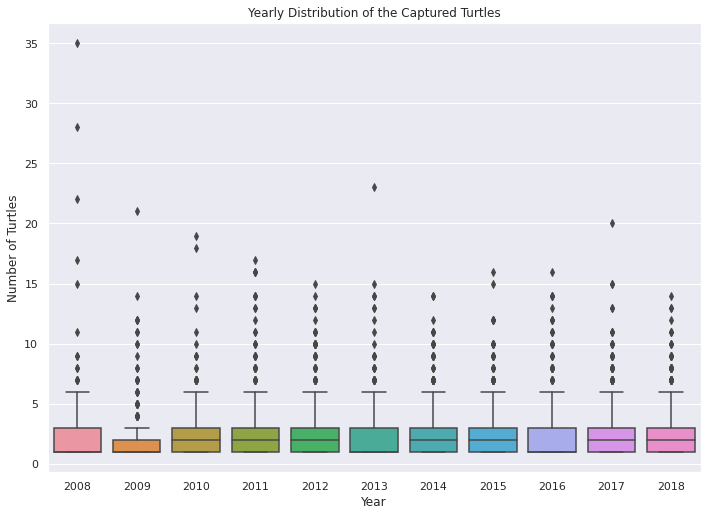

In [27]:
sns.boxplot(x="Date_TimeCaughtYear", y="Capture_Number", 
            data=trainTurtle[
                (trainTurtle["Date_TimeCaughtYear"] > 2007) & (trainTurtle["Date_TimeCaughtYear"] < 2019)]
           ).set(title="Yearly Distribution of the Captured Turtles", xlabel="Year", 
                 ylabel="Number of Turtles")

Evidence of outliers are visible in the boxplots

[Text(0, 0.5, 'Rescued Turtles'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Yearly Distribution of the Number of Turtles Captured (SUM)')]

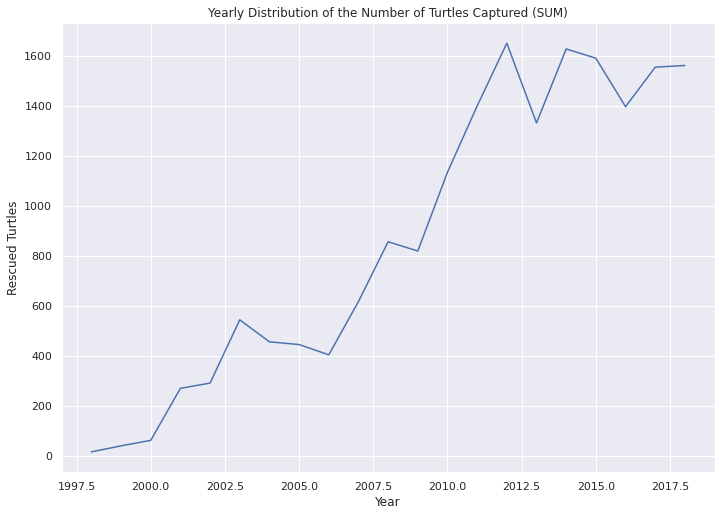

In [28]:
sns.lineplot(x="Date_TimeCaughtYear", y="Capture_Number", 
             data=trainTurtle.groupby(
                 ["Date_TimeCaughtYear"])["Capture_Number"].agg("sum").reset_index()
            ).set(title="Yearly Distribution of the Number of Turtles Captured (SUM)", xlabel="Year", 
                  ylabel="Rescued Turtles")

Between 1998 and 2018, there has been a positive trend. This simply means, the number of rescued sea turtles has been increasing across the decades.

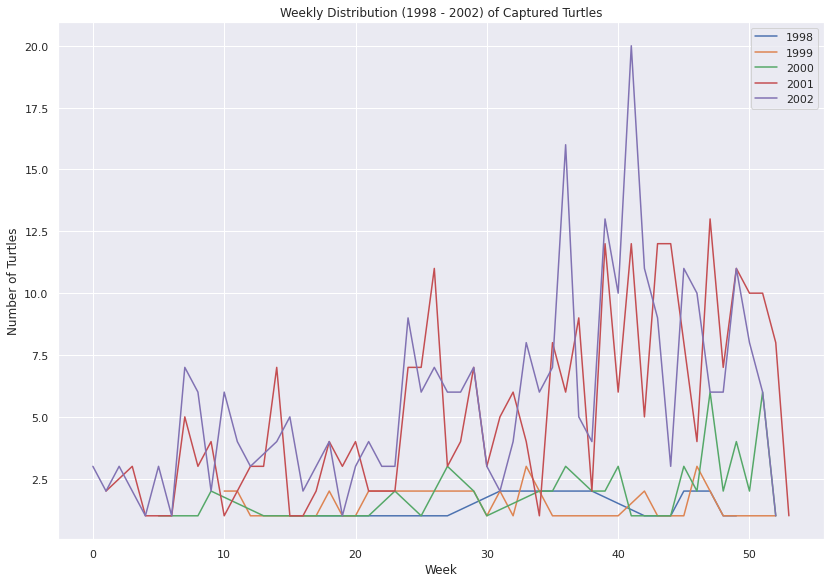

In [29]:
years = sorted(trainTurtle["Date_TimeCaughtYear"].unique().tolist())

for year in years[:5]:
    sns.lineplot(x="Date_TimeCaughtWeek", y="Capture_Number", label=year, 
                 data=trainTurtle[
                     trainTurtle["Date_TimeCaughtYear"] == year
                 ].groupby(["Date_TimeCaughtWeek"])["Capture_Number"].agg("sum").reset_index()
                ).set(title="Weekly Distribution (1998 - 2002) of Captured Turtles", xlabel="Week", 
                      ylabel="Number of Turtles")

plt.tight_layout()

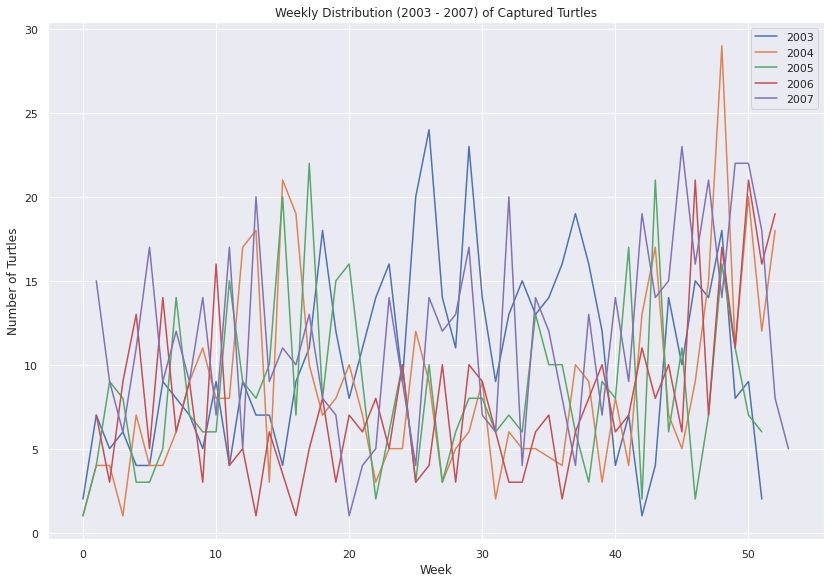

In [30]:
for year in years[5:10]:
    sns.lineplot(x="Date_TimeCaughtWeek", y="Capture_Number", label=year, 
                 data=trainTurtle[
                     trainTurtle["Date_TimeCaughtYear"] == year
                 ].groupby(["Date_TimeCaughtWeek"])["Capture_Number"].agg("sum").reset_index()
                ).set(title="Weekly Distribution (2003 - 2007) of Captured Turtles", xlabel="Week", 
                      ylabel="Number of Turtles")

plt.tight_layout()

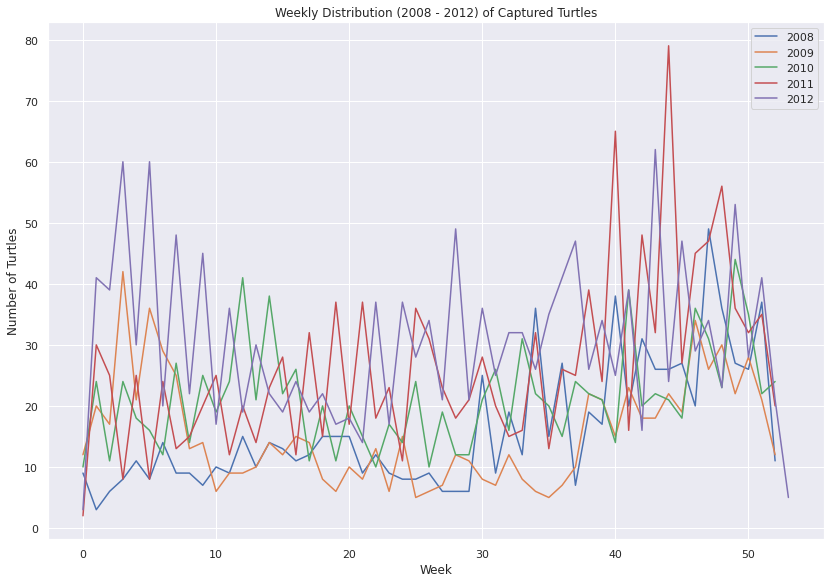

In [31]:
for year in years[10:15]:
    sns.lineplot(x="Date_TimeCaughtWeek", y="Capture_Number", label=year, 
                 data=trainTurtle[
                     trainTurtle["Date_TimeCaughtYear"] == year
                 ].groupby(["Date_TimeCaughtWeek"])["Capture_Number"].agg("sum").reset_index()
                ).set(title="Weekly Distribution (2008 - 2012) of Captured Turtles", xlabel="Week", 
                      ylabel="Number of Turtles")

plt.tight_layout()

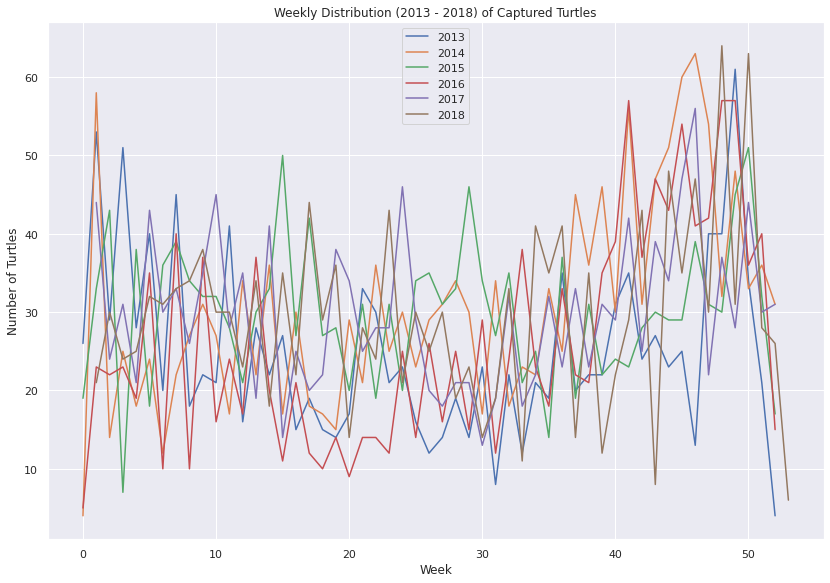

In [32]:
for year in years[15:]:
    sns.lineplot(x="Date_TimeCaughtWeek", y="Capture_Number", label=year, 
                 data=trainTurtle[
                     trainTurtle["Date_TimeCaughtYear"] == year
                 ].groupby(["Date_TimeCaughtWeek"])["Capture_Number"].agg("sum").reset_index()
                ).set(title="Weekly Distribution (2013 - 2018) of Captured Turtles", xlabel="Week", 
                      ylabel="Number of Turtles")

plt.tight_layout()

[Text(0, 0.5, 'Number of Turtles'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Yearly Distribution of the Number of Turtles (MEAN)')]

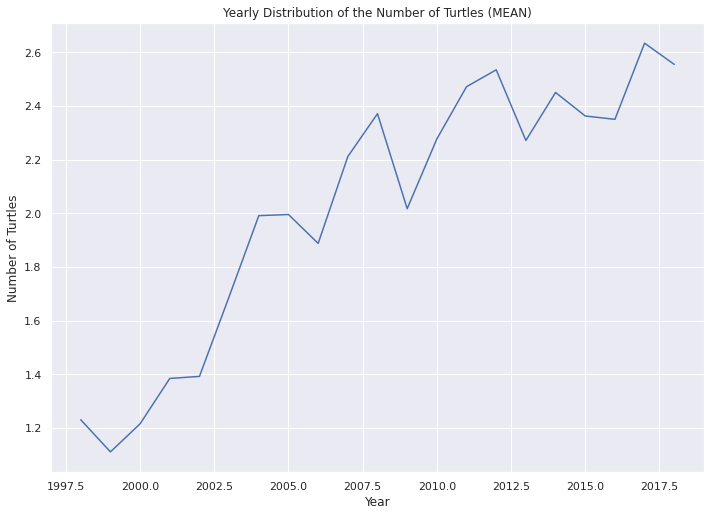

In [33]:
sns.lineplot(x="Date_TimeCaughtYear", y="Capture_Number", 
             data=trainTurtle.groupby(["Date_TimeCaughtYear"])["Capture_Number"].agg("mean").reset_index()
            ).set(title="Yearly Distribution of the Number of Turtles (MEAN)", xlabel="Year", 
                  ylabel="Number of Turtles")

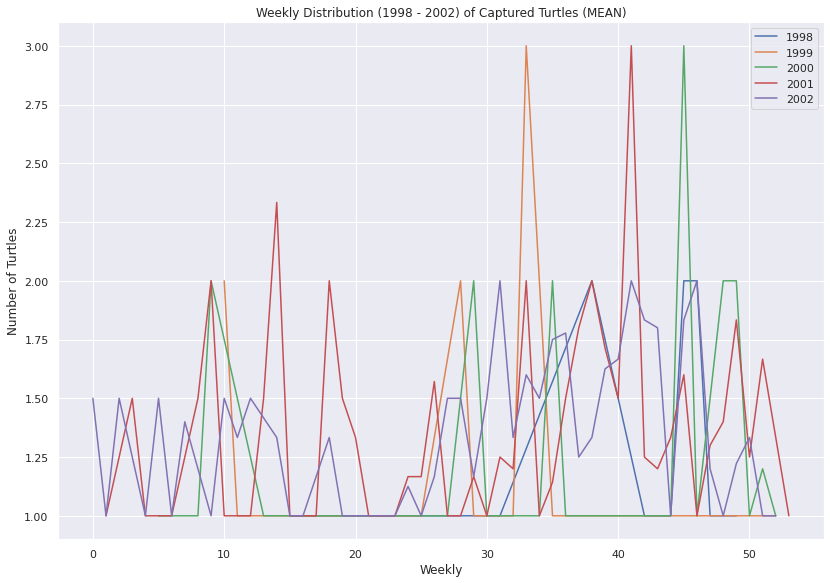

In [34]:
years = sorted(trainTurtle["Date_TimeCaughtYear"].unique().tolist())

for year in years[:5]:
    sns.lineplot(x="Date_TimeCaughtWeek", y="Capture_Number", label=year, 
                 data=trainTurtle[
                     trainTurtle["Date_TimeCaughtYear"] == year
                 ].groupby(["Date_TimeCaughtWeek"])["Capture_Number"].agg("mean").reset_index()
                ).set(title="Weekly Distribution (1998 - 2002) of Captured Turtles (MEAN)", xlabel="Weekly", 
                      ylabel="Number of Turtles")

plt.tight_layout()

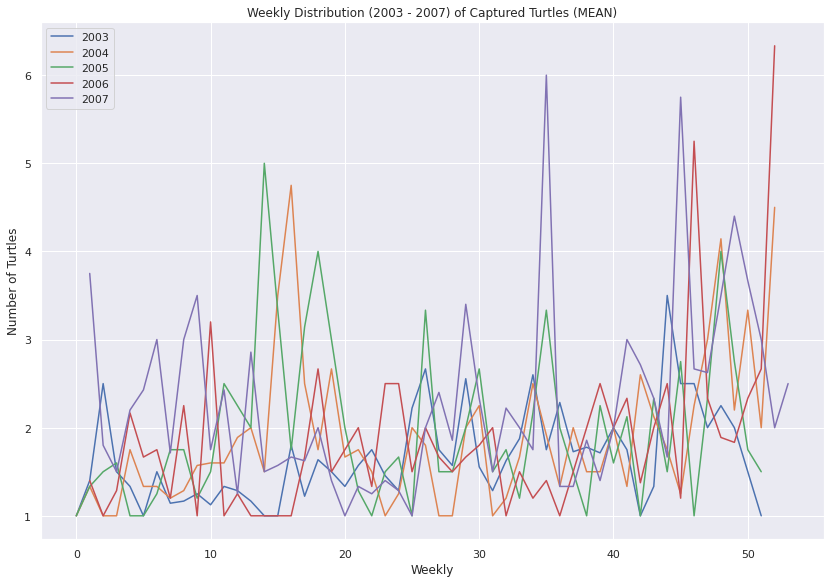

In [35]:
for year in years[5:10]:
    sns.lineplot(x="Date_TimeCaughtWeek", y="Capture_Number", label=year, 
                 data=trainTurtle[
                     trainTurtle["Date_TimeCaughtYear"] == year
                 ].groupby(["Date_TimeCaughtWeek"])["Capture_Number"].agg("mean").reset_index()
                ).set(title="Weekly Distribution (2003 - 2007) of Captured Turtles (MEAN)", xlabel="Weekly", 
                      ylabel="Number of Turtles")

plt.tight_layout()

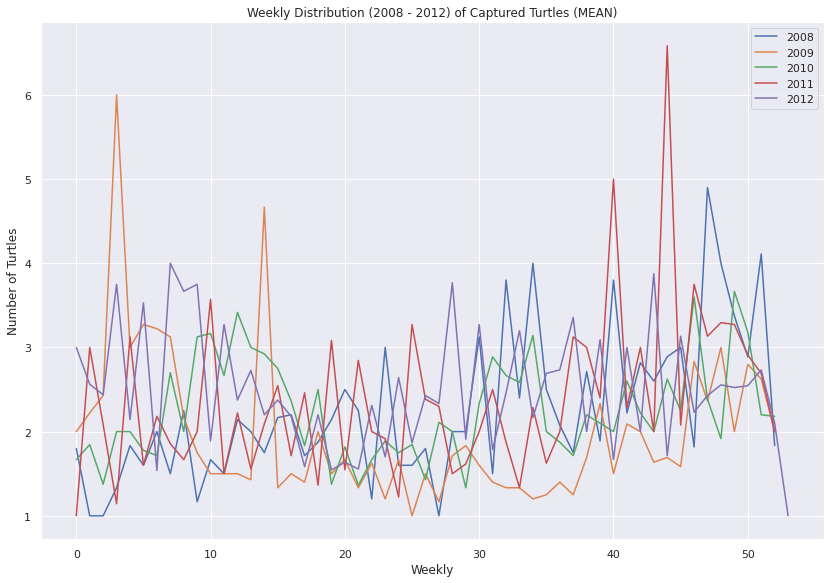

In [36]:
for year in years[10:15]:
    sns.lineplot(x="Date_TimeCaughtWeek", y="Capture_Number", label=year, 
                 data=trainTurtle[
                     trainTurtle["Date_TimeCaughtYear"] == year
                 ].groupby(["Date_TimeCaughtWeek"])["Capture_Number"].agg("mean").reset_index()
                ).set(title="Weekly Distribution (2008 - 2012) of Captured Turtles (MEAN)", xlabel="Weekly", 
                      ylabel="Number of Turtles")

plt.tight_layout()

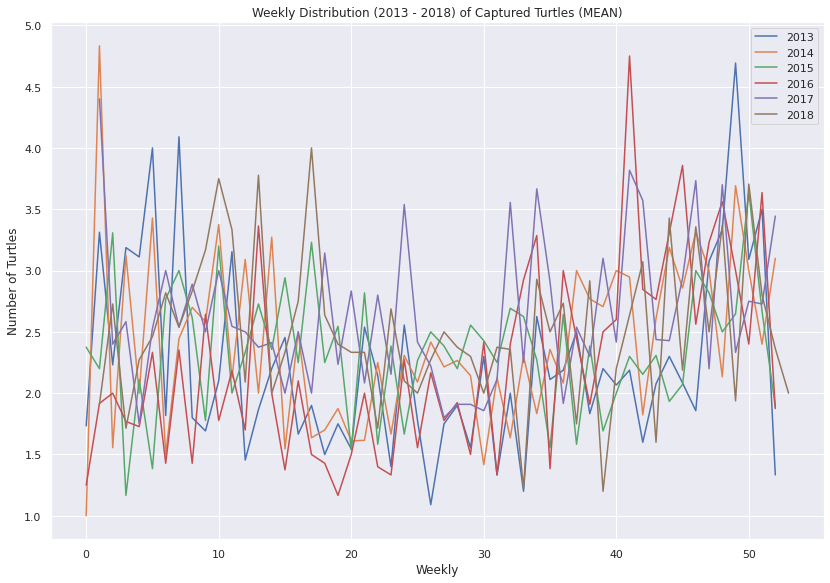

In [37]:
for year in years[15:]:
    sns.lineplot(x="Date_TimeCaughtWeek", y="Capture_Number", label=year, 
                 data=trainTurtle[
                     trainTurtle["Date_TimeCaughtYear"] == year
                 ].groupby(["Date_TimeCaughtWeek"])["Capture_Number"].agg("mean").reset_index()
                ).set(title="Weekly Distribution (2013 - 2018) of Captured Turtles (MEAN)", xlabel="Weekly", 
                      ylabel="Number of Turtles")

plt.tight_layout()

In [38]:
trainTurtle["SMA_5"] = trainTurtle["Capture_Number"].rolling(5, min_periods=1).mean()
trainTurtle["SMA_10"] = trainTurtle["Capture_Number"].rolling(10, min_periods=1).mean()

In [39]:
trainTurtle[["SMA_5", "SMA_10"]].head()

,SMA_5,SMA_10
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.2,1.2
